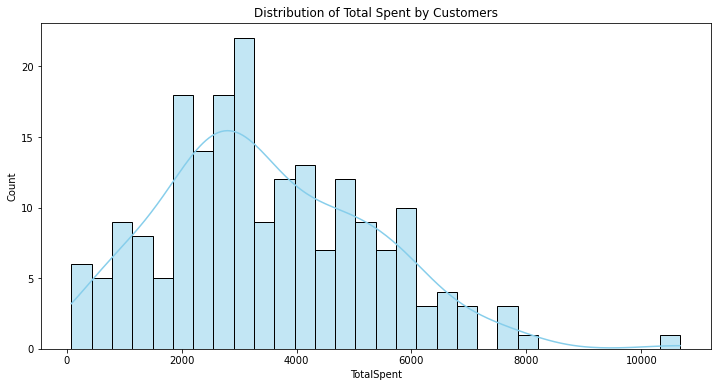

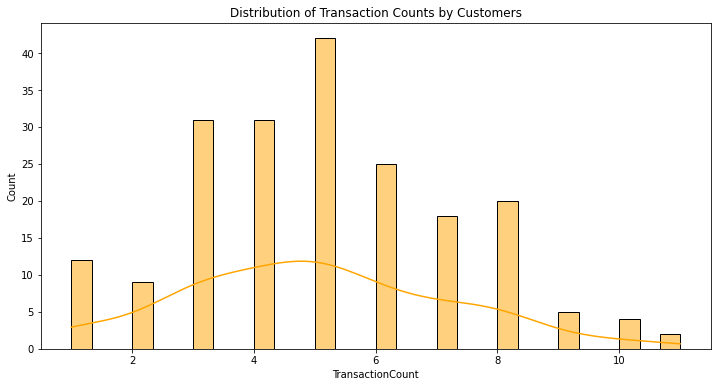

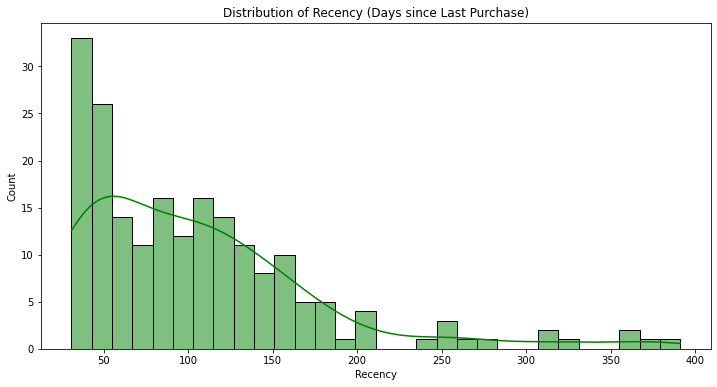

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings('ignore')

# Load datasets
products = pd.read_csv(r'C:\Users\Akanksha\Downloads\Products.csv')
transactions = pd.read_csv('C:/Users/Akanksha/Downloads/Transactions.csv')
customers = pd.read_csv('C:/Users/Akanksha/Downloads/Customers.csv')

# Merge datasets based on CustomerID
merged_data = pd.merge(transactions, customers, on='CustomerID')

# Feature Engineering
def calculate_days_since_last_purchase(dates):
    return (pd.to_datetime('today') - pd.to_datetime(dates.max())).days

customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'TransactionDate': calculate_days_since_last_purchase
}).reset_index()

customer_features.columns = ['CustomerID', 'TotalSpent', 'TransactionCount', 'Recency']

# Scale the features for similarity calculation
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalSpent', 'TransactionCount', 'Recency']])

# Compute pairwise Euclidean distances
def calculate_similarity(base_vector, all_vectors):
    return [1 / (1 + euclidean(base_vector, vector)) if np.any(vector) else 0 for vector in all_vectors]

lookalikes = {}

# Generate lookalike recommendations
for idx, customer_id in enumerate(customer_features['CustomerID']):
    base_vector = scaled_features[idx]
    similarity_scores = calculate_similarity(base_vector, scaled_features)

    # Select top 3 most similar customers excluding the customer itself
    similar_indices = np.argsort(similarity_scores)[-4:-1][::-1]
    similar_customers = customer_features['CustomerID'].iloc[similar_indices].tolist()
    scores = np.array(similarity_scores)[similar_indices].tolist()

    lookalikes[customer_id] = list(zip(similar_customers, scores))

# Filter results for Customer IDs C0001 to C0020
lookalike_list = []
for cust_id in customer_features['CustomerID'][:20]:
    if cust_id in lookalikes:
        for similar_cust, score in lookalikes[cust_id]:
            lookalike_list.append([cust_id, similar_cust, score])

# Create a DataFrame for the lookalike mapping
lookalike_df = pd.DataFrame(lookalike_list, columns=['CustomerID', 'LookalikeID', 'SimilarityScore'])

# Save the result as a CSV
lookalike_df.to_csv('Lookalike.csv', index=False)

# Visualization of Features Distribution
plt.figure(figsize=(12, 6))
sns.histplot(customer_features['TotalSpent'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Total Spent by Customers')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(customer_features['TransactionCount'], bins=30, kde=True, color='orange')
plt.title('Distribution of Transaction Counts by Customers')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(customer_features['Recency'], bins=30, kde=True, color='green')
plt.title('Distribution of Recency (Days since Last Purchase)')
plt.show()

